In [20]:
from diffusers import DiffusionPipeline
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

pipeline = DiffusionPipeline.from_pretrained(
    'runwayml/stable-diffusion-v1-5', safety_checker=None)

scheduler = pipeline.scheduler
tokenizer = pipeline.tokenizer

del pipeline

device, scheduler, tokenizer

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


('cuda',
 PNDMScheduler {
   "_class_name": "PNDMScheduler",
   "_diffusers_version": "0.27.0.dev0",
   "beta_end": 0.012,
   "beta_schedule": "scaled_linear",
   "beta_start": 0.00085,
   "clip_sample": false,
   "num_train_timesteps": 1000,
   "prediction_type": "epsilon",
   "set_alpha_to_one": false,
   "skip_prk_steps": true,
   "steps_offset": 1,
   "timestep_spacing": "leading",
   "trained_betas": null
 },
 CLIPTokenizer(name_or_path='C:\Users\37026\.cache\huggingface\hub\models--runwayml--stable-diffusion-v1-5\snapshots\1d0c4ebf6ff58a5caecab40fa1406526bca4b5b9\tokenizer', vocab_size=49408, model_max_length=77, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|startoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
 	49406: AddedToken("<|startoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=T

In [21]:
%run encoder.ipynb
%run vae.ipynb
%run unet.ipynb
encoder = torch.load('./saves/encoder.model')
#unet = torch.load('./saves/unet2.pth')


encoder.to(device)
vae.to(device)
unet.to(device)

encoder.eval()
vae.eval()
unet.eval()

UNet(
  (in_vae): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (in_time): Sequential(
    (0): Linear(in_features=320, out_features=1280, bias=True)
    (1): SiLU()
    (2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_block0): DownBlock(
    (res0): Resnet(
      (time): Sequential(
        (0): SiLU()
        (1): Linear(in_features=1280, out_features=320, bias=True)
        (2): Unflatten(dim=1, unflattened_size=(320, 1, 1))
      )
      (s0): Sequential(
        (0): GroupNorm(32, 320, eps=1e-05, affine=True)
        (1): SiLU()
        (2): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (s1): Sequential(
        (0): GroupNorm(32, 320, eps=1e-05, affine=True)
        (1): SiLU()
        (2): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (res1): Resnet(
      (time): Sequential(
        (0): SiLU()
        (1): Linear(in_features=1280, out_features=320, bias=True

In [22]:
@torch.no_grad()
def generate(text,neg_text=''):
    #text to tensor
    #[1, 77]
    pos = tokenizer(text,
                    padding='max_length',
                    max_length=77,
                    truncation=True,
                    return_tensors='pt').input_ids.to(device)
    neg = tokenizer(neg_text,
                    padding='max_length',
                    max_length=77,
                    truncation=True,
                    return_tensors='pt').input_ids.to(device)

    #[1, 77, 768]
    pos = encoder(pos)[0]
    neg = encoder(neg)[0]

    #[1+1, 77, 768] -> [2, 77, 768]
    out_encoder = torch.cat((neg, pos), dim=0)

    #vae noise image
    out_vae = torch.randn(1, 4, 64, 64, device=device)

    #50 time steps
    scheduler.set_timesteps(50, device=device)
    for time in scheduler.timesteps:

        #add noise
        #[1+1, 4, 64, 64] -> [2, 4, 64, 64]
        noise = torch.cat((out_vae, out_vae), dim=0)
        noise = scheduler.scale_model_input(noise, time)

        #calc noise
        #[2, 4, 64, 64],[2, 77, 768],scala -> [2, 4, 64, 64]
        pred_noise = unet(out_vae=noise, out_encoder=out_encoder, time=time)

        #pos-neg
        #[2, 4, 64, 64] -> [1, 4, 64, 64]
        pred_noise = pred_noise[0] + 7.5 * (pred_noise[1] - pred_noise[0])

        #add more noise
        #[1, 4, 64, 64]
        out_vae = scheduler.step(pred_noise, time, out_vae).prev_sample

    #output to decoder
    out_vae = 1 / 0.18215 * out_vae
    #[1, 4, 64, 64] -> [1, 3, 512, 512]
    image = vae.decoder(out_vae)

    #into image
    image = image.cpu()
    image = (image + 1) / 2
    image = image.clamp(0, 1)
    image = image.permute(0, 2, 3, 1)
    return image.numpy()[0]




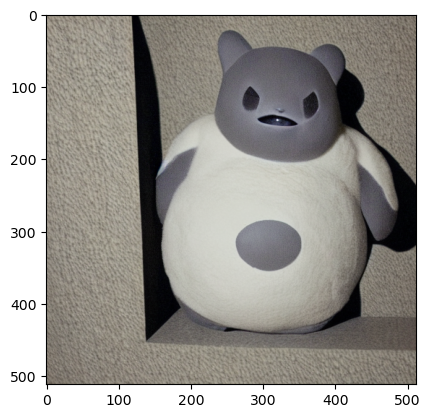

In [23]:

pic = generate('a dark photo of the [snorlax_bear]')
from matplotlib import pyplot as plt
plt.imshow(pic)
plt.show()

In [24]:
a=[1,2,3,4,5,6,7,8,9,10]
b=[2,'eee']
a+=b
a

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 2, 'eee']